In [7]:
import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
import datetime
from fit.modules.SResTransformerModule import SResTransformerModule
import wandb 
from matplotlib import pyplot as plt
from matplotlib import gridspec

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
from os.path import exists
import wget
import ssl
import torchvision
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
seed_everything(22122020)

Seed set to 22122020


22122020

In [9]:
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=8)
dm.prepare_data()
dm.setup()

In [10]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [11]:
n_heads = 8
d_query = 32

In [12]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 4)

model.load_test_model('/home/aman.kukde/Projects/FourierImageTransformer/models_saved/04-03_23-23-38_sum_+/epoch=254-step=438345.ckpt')
# model.cuda()
tokeniser_weights = torch.load('/home/aman.kukde/Projects/FourierImageTransformer/model.ckpt')['state_dict']
for key in list(tokeniser_weights.keys()):
    if '.encoder' in key:
        del tokeniser_weights[key]

def load_partial_state_dict(model, state_dict):
    own_state = model.state_dict()
    for name, param in state_dict.items():
        if name in own_state:
            print(f'Copying {name}')
            if own_state[name].size() == param.size():
                own_state[name].copy_(param)
                own_state[name].requires_grad = False
                own_state[name].training = False
        # else:
        #     print(f'Layer {name} not found in current model')
    model.load_state_dict(tokeniser_weights, strict=False)
    return model

model = load_partial_state_dict(model, tokeniser_weights)

trainer = Trainer(max_epochs=100, 
                  #gpus=1, # set to 0 if you want to run on CPU
                  callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            mode='min'
                                        ), 
                  deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Copying sres.fourier_coefficient_embedding.weight
Copying sres.fourier_coefficient_embedding.bias
Copying sres.predictor_amp.weight
Copying sres.predictor_amp.bias
Copying sres.predictor_phase.weight
Copying sres.predictor_phase.bias


In [13]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [24]:
fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')

In [41]:
from fit.utils.utils import denormalize


x_fc = fc[:, flatten_order][:, :96]
pred = model.sres.forward_i(x_fc,96)

pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)


In [43]:
pred

tensor([[[-0.9923,  0.0226],
         [ 0.9650, -0.8106],
         [ 1.0093,  0.8259],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [ 0.0617, -0.0071]],

        [[-0.9923,  0.0226],
         [ 0.9650, -0.8106],
         [ 1.0093,  0.8259],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [ 0.0617, -0.0071]],

        [[-0.9923,  0.0226],
         [ 0.9650, -0.8106],
         [ 1.0093,  0.8259],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [ 0.0617, -0.0071]],

        ...,

        [[-0.9923,  0.0226],
         [ 0.9650, -0.8106],
         [ 1.0093,  0.8259],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [ 0.0617, -0.0071]],

        [[-0.9923,  0.0226],
         [ 0.9650, -0.8106],
         [ 1.0093,  0.8259],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [ 0.0617, -0.0071]],

        [[-0.9923,  0.0226],
       

In [31]:
lowres = torch.zeros_like(pred)
lowres += fc.min()
lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)


# lowres_img = denormalize(lowres_img, model.trainer.datamodule.mean, model.trainer.datamodule.std)
# pred_img = denormalize(pred_img, .mean, model.trainer.datamodule.std)
# gt_img = denormalize(gt_img, model.trainer.datamodule.mean, model.trainer.datamodule.std)

lowres_psnr = PSNR(gt_img,lowres_img)#[PSNR(gt_img[i], lowres_img[i], drange=torch.tensor(255., dtype=torch.float32)) for i in
                #range(gt_img.shape[0])]
pred_psnr = PSNR(gt_img,pred_img)#[PSNR(gt_img[i], pred_img[i], drange=torch.tensor(255., dtype=torch.float32)) for i in
                #range(gt_img.shape[0])]
print(lowres_psnr, pred_psnr)

tensor([21.7900, 21.7900, 21.7900, 21.7900, 21.7900, 21.7900, 21.7900, 21.7900],
       device='cuda:0') tensor([nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')


In [32]:
for i in [pred_img, lowres_img, gt_img]: i.cpu()

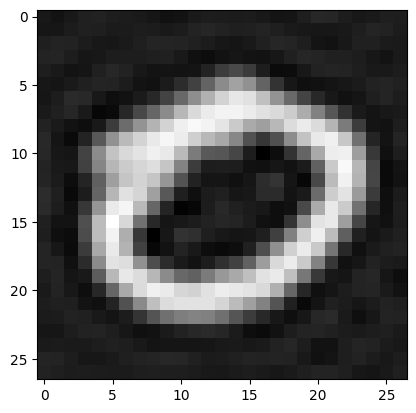

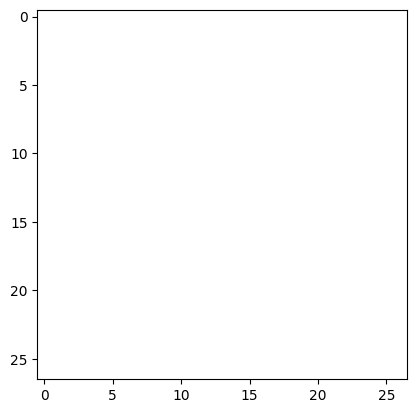

In [33]:
plt.imshow(lowres_img[0].cpu(), cmap='gray')
plt.show()
plt.imshow(pred_img[0].cpu(), cmap='gray')

In [14]:
PSNR(gt_img,lowres_img) - PSNR(gt_img,pred_img)

tensor([4.1630, 4.1630, 4.1630, 4.1630, 4.1630, 4.1630, 4.1630, 4.1630],
       device='cuda:0')

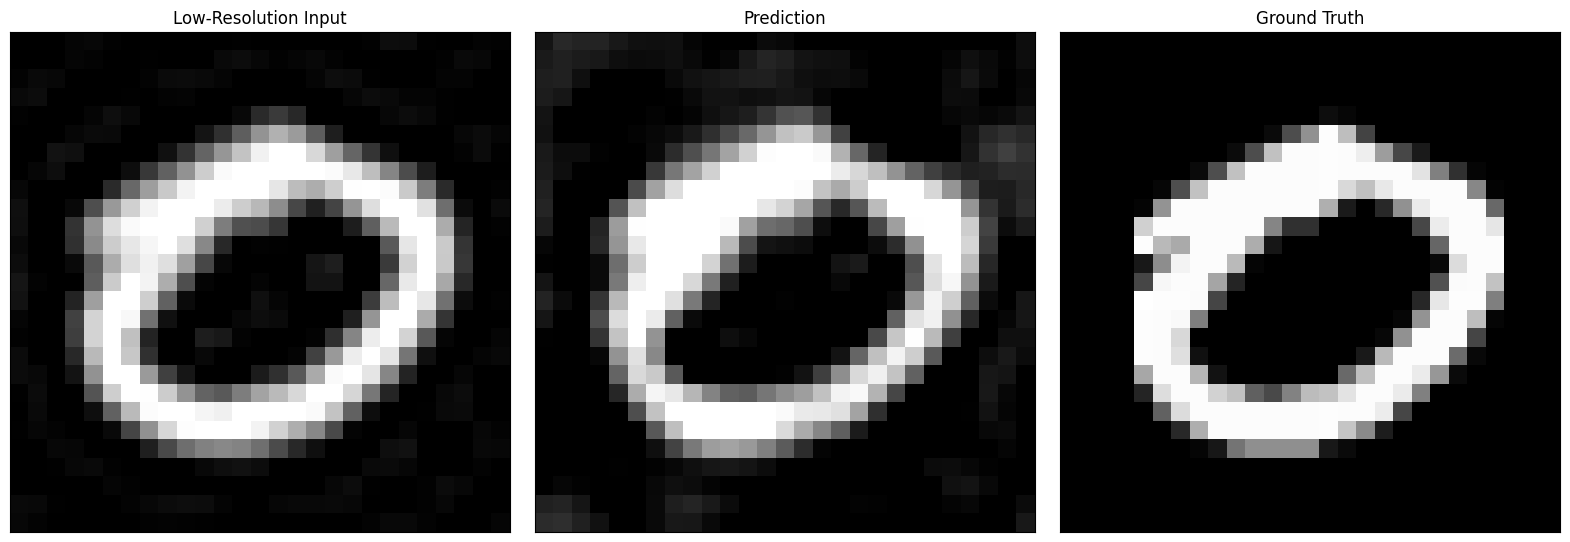

In [15]:
for sample in range(1):
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray', vmin=gt_img[sample].cpu().min(), vmax=gt_img[sample].cpu().max())
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray', vmin=gt_img[sample].cpu().min(), vmax=gt_img[sample].cpu().max())
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

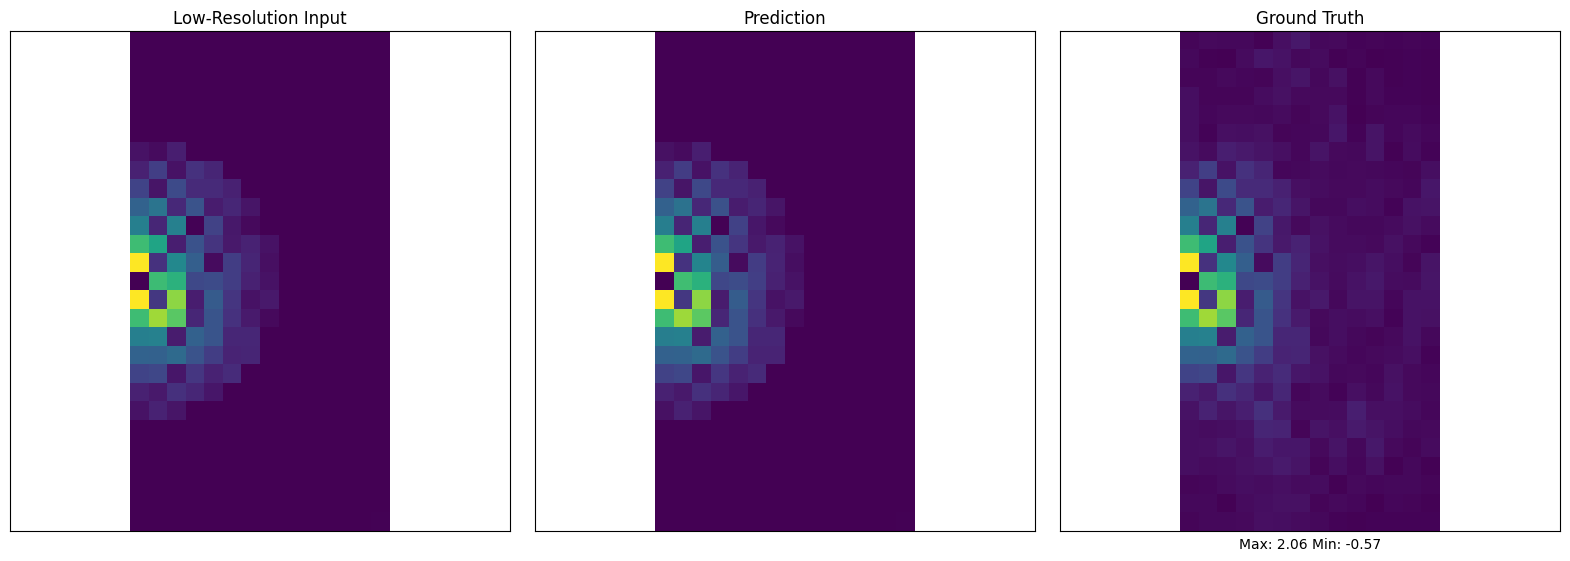

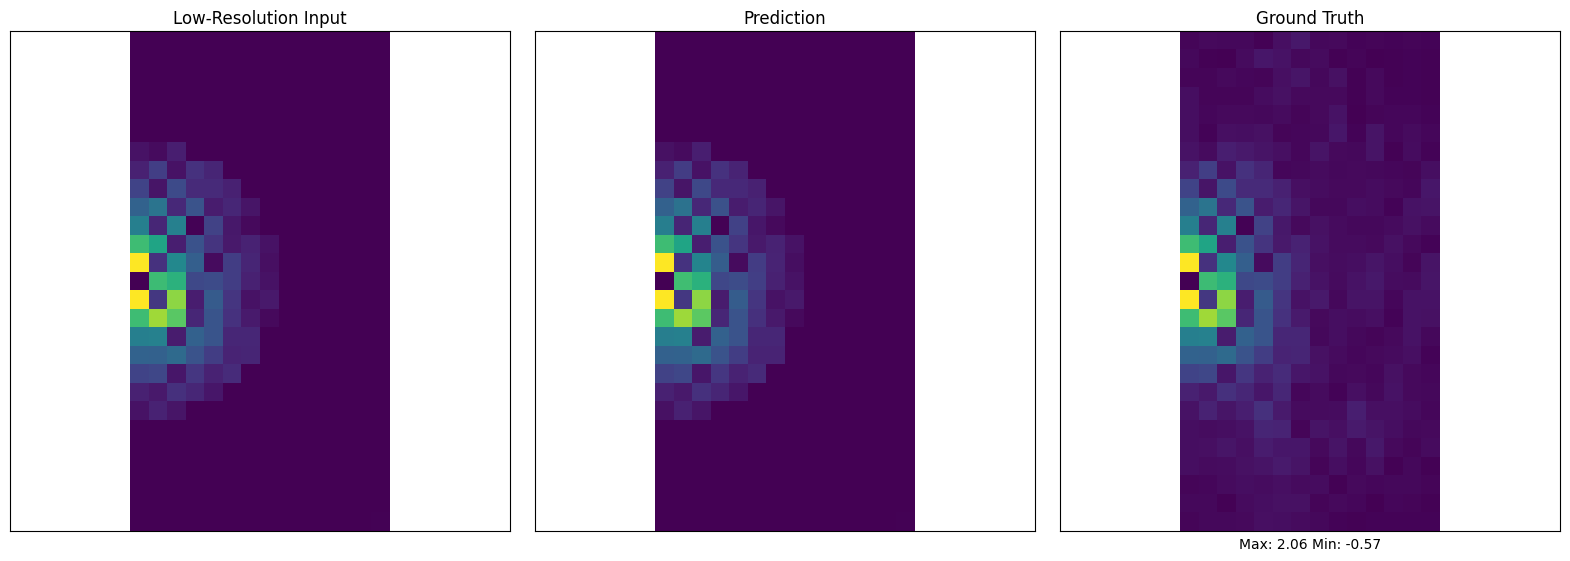

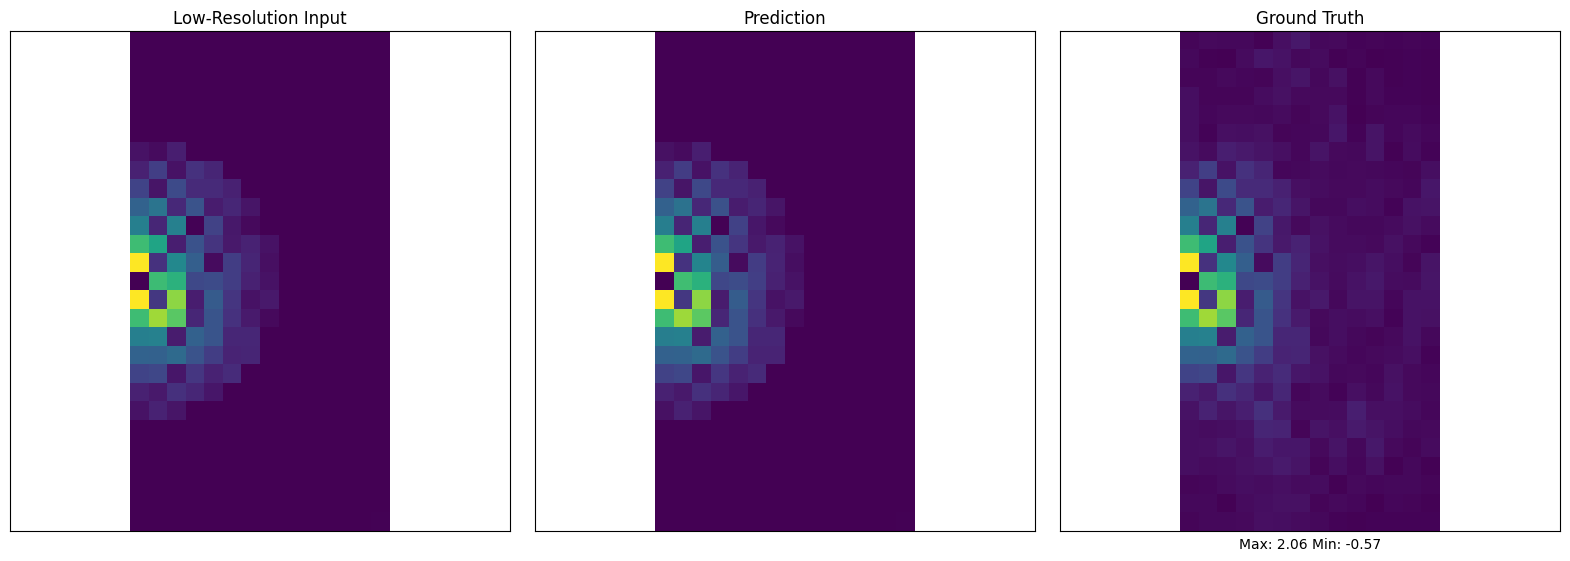

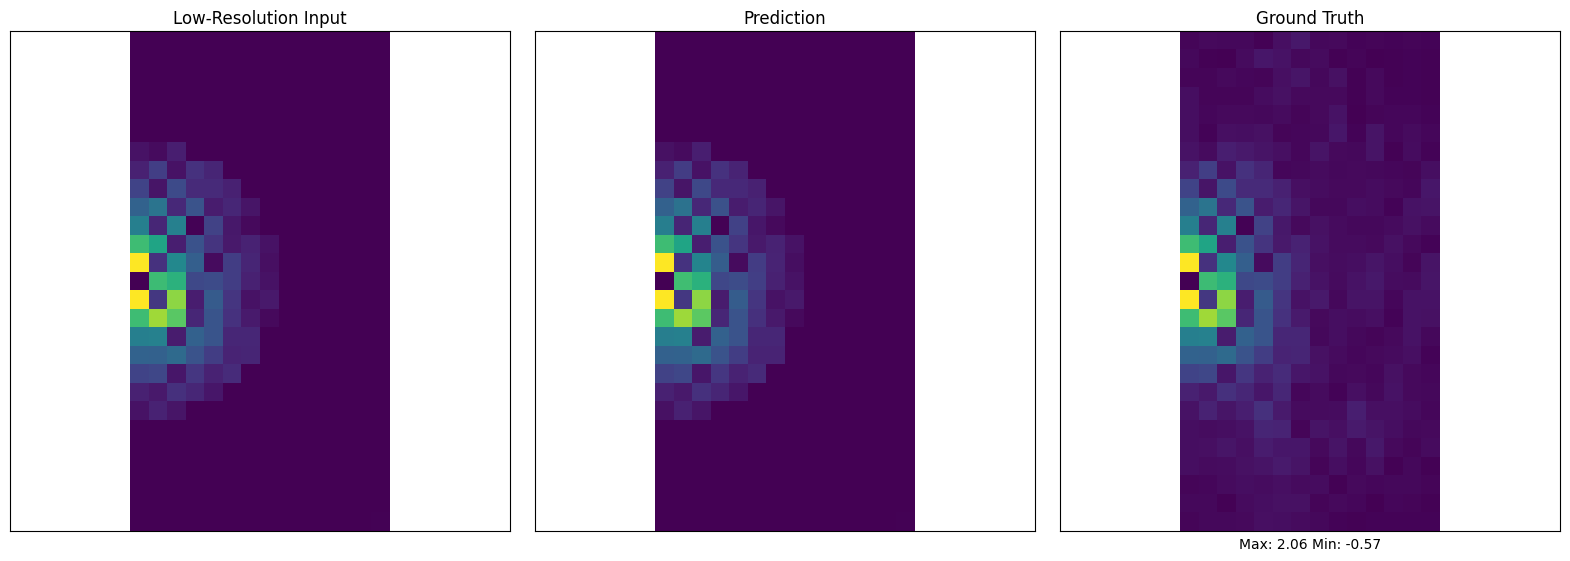

In [16]:
diff = []
lowres_scaled = torch.zeros_like(lowres_img)
pred_img_scaled = torch.zeros_like(pred_img)
for i in range(4):
    sample = i
    # pred_img_scaled[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_scaled[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    # lowres_scaled_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_scaled[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    # ax0.set_xlabel(f'PSNR: {lowres_scaled_vs_gt_img_psnr:.2f} dB\nMax: {lowres_scaled[sample].cpu().max():.2f} Min: {lowres_scaled[sample].cpu().min():.2f}');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img_scaled[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    # ax1.set_xlabel(f'PSNR: {pred_vs_gt_img_psnr:.2f} dB\nMax: {pred_img_scaled[sample].cpu().max():.2f} Min: {pred_img_scaled[sample].cpu().min():.2f}');
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    # diff.append(lowres_vs_gt_img_psnr - pred_vs_gt_img_psnr)

In [ ]:
dummy = torch.zeros(3,10,5)

In [ ]:
x = torch.randn(3,2,5)

In [ ]:
dummy[:,:2,:] = x

In [ ]:
dummy